In [43]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
import csv
from collections import Counter
import random
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from matplotlib import pyplot as plt
import math
import re
from patsy import dmatrices
from nltk.corpus import stopwords

Populating the interactive namespace from numpy and matplotlib


In [2]:
job_data = pd.read_csv('Train_rev1.csv')

**Taking random 2500 data points**

In [4]:
job_data = job_data.sample(n=2500, random_state = 99)

A1. What are the top 5 parts of speech in the job descriptions? How frequently do they appear? How do these numbers change if you exclude stopwords? 

In [41]:
# Make Word corpus:
job_data_list = job_data["FullDescription"].tolist()

In [44]:
tokenized_words = []
for item in job_data_list:
    words = []
    words = nltk.word_tokenize(item.lower())
    tokenized_words = tokenized_words + words

In [45]:
tokenized_words_string = " ".join(str(x) for x in tokenized_words)
for p in punctuation:
    tokenized_words_string=tokenized_words_string.replace(p,'')

In [46]:
# POS Tagging
job_descriptions_tagged = nltk.pos_tag(nltk.word_tokenize(tokenized_words_string))
#tokenized_words_string

In [47]:
# Find the frequency of tags
tag_fd = nltk.FreqDist(tag for (word, tag) in job_descriptions_tagged)
tag_fd.most_common()[:5]

[('NN', 156791), ('JJ', 70755), ('IN', 65478), ('DT', 50604), ('NNS', 50447)]

The most common parts of speech with removing stop words are nouns, adjective, preposition, Determiner, and Noun plural

In [48]:
# Remove stop words
stop_words = set(stopwords.words('english'))
word_tokenize = nltk.word_tokenize(tokenized_words_string)
filtered_sentence = [w for w in word_tokenize if not w in stop_words]

In [49]:
tokenized_words_without_stopwords = " ".join(str(x) for x in filtered_sentence)

job_descriptions_tagged_without_stopwords = nltk.pos_tag(nltk.word_tokenize(tokenized_words_without_stopwords))
tag_fd = nltk.FreqDist(tag for (word, tag) in job_descriptions_tagged_without_stopwords)
tag_fd.most_common()[:5]

[('NN', 151266), ('JJ', 72996), ('NNS', 49954), ('VBG', 25541), ('VBP', 16847)]

The top most frequent POS are now noun, adjective, plural noun, verb and verb - singular present

A2. Does this data support Zipf’s law? Plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

Text(0,0.5,'Word Frequency')

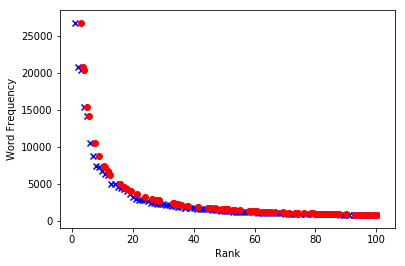

In [50]:
all_words = nltk.FreqDist((nltk.word_tokenize(tokenized_words_string)))

topwords = all_words.most_common(100)
frequency = []
for (word, freq) in topwords:
    frequency.append(freq)

frequency = pd.Series(frequency)

# Get the observational rank
word_ranking = frequency.rank(method = 'min',ascending =False)

# Plot obseravtional and theoritical rank
def theoretical_rank(freq):
    # We will take the frequency of the words to calculate the theoritical rank using variation of Zipf's Law
    rank = math.exp((-1)*(np.log(freq) - np.log(max(word_ranking)*min(frequency))))
    return rank

# get the theoretical ranks for the frequencies observed
theoretical_rank = frequency.map(theoretical_rank)
plt.scatter(word_ranking,frequency,color = 'blue', marker = 'x',label = 'Frequency vs observed rank')
plt.scatter(theoretical_rank,frequency,color = 'red',marker = 'o',label = 'Frequency vs theoritical rank')
plt.xlabel('Rank')
plt.ylabel('Word Frequency')

**A3. If we remove stopwords and lemmatize the data, what are the 10 most common words? What are their frequencies?**

In [51]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
def get_pos( word ):
    w_synsets = wordnet.synsets(word)

    pos_counts = Counter()
    pos_counts["n"] = len(  [ item for item in w_synsets if item.pos()=="n"]  )
    pos_counts["v"] = len(  [ item for item in w_synsets if item.pos()=="v"]  )
    pos_counts["a"] = len(  [ item for item in w_synsets if item.pos()=="a"]  )
    pos_counts["r"] = len(  [ item for item in w_synsets if item.pos()=="r"]  )
    
    most_common_pos_list = pos_counts.most_common(3)
    return most_common_pos_list[0][0]

wordnet_lemmatizer = WordNetLemmatizer()
word_lematized = [wordnet_lemmatizer.lemmatize(w,pos=get_pos(w)) for w in filtered_sentence] 

word_lematized_words = Counter(word_lematized)
most_common_words = word_lematized_words.most_common()
most_common_words[:10]

[('work', 5283),
 ('experience', 5118),
 ('role', 3163),
 ('team', 3060),
 ('client', 2996),
 ('business', 2864),
 ('service', 2444),
 ('skill', 2424),
 ('sale', 2212),
 ('within', 2181)]

The top words after removing stop words and stemming are work, experience, role, team, client, business, service, skill, sale and within

## Part B (predict salary from job description; the idea here is to test the predictive power of text and compare it with that of numeric data)

**Let us first create our data frame and clean up some of the data so that we can use it for prediction**

Creating a column for high/low salaries - We wil consider the top 25th percentile ( >75th quantile) salaries as high and remainig as low salaries

In [122]:
import warnings
warnings.filterwarnings('ignore')
job_data['Salary'] = 0
job_data['Salary'][job_data['SalaryNormalized']> job_data['SalaryNormalized'].quantile(0.75)] = 1

Let us convert the locations with high living costs to 1 and the other loctions to 0.

In [123]:
highlivingcost = ['oxford','uk','the city','greater london','central london','london','south east london',\
                  'winchester', 'cambridge', 'chichester', 'brighon and hove', 'bath', 'southhampton',\
                  'salisbury','canterbury','st albans', 'bristol','lichfield','truro','norwich','chelmsford',\
                  'exeter','york','leicester','gloucester']

def living_cost(s):
    if s.lower() in highlivingcost:
        return 1
    else:
        return 0

job_data['cost_of_living'] = job_data['LocationNormalized'].apply(living_cost)

Let us clean the job descriptions to remove punctuations and numbers from textua data

In [124]:
def removepunc(item):
    for p in punctuation:
        item = item.replace(p,'')
    return item

def remove_numbers(s):
    return re.sub("\S*\d\S*", "", s).strip()

def lowerize(x):
    return x.lower()

job_data['CleanDescription'] = job_data['FullDescription'].apply(removepunc).apply(lowerize).apply(remove_numbers)

**B1. Ignore the job descriptions, and train a model to predict high/low salary from all the numeric columns, e.g., part time/full time, contract vs. others, type of job (a lot of dummy variables), location (instead of using a huge number of dummy variables, you can use a list of cities in England with highest cost of living, and create a 0/1 variable which is 1 if the job is in one of those cities, else 0). Use the Naïve Bayes classifier. What is the accuracy of your model?**   

In [125]:
# Let us remove the columns which we do not need for the prediction 
job_data_for_prediction = job_data[['ContractType','ContractTime','Category','Salary',\
                                    'cost_of_living']]
job_data_dummies = pd.get_dummies(job_data_for_prediction)
column_names = job_data_dummies.loc[:, job_data_dummies.columns != 'Salary'].columns.values
formula = 'Salary ~ 0 + {}'.format(' + '.join(['Q("{}")'.format(x) for x in column_names]))

Y, X = dmatrices(formula, job_data_dummies, return_type='dataframe')
y = Y['Salary'].values

#Split the data into train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 99)

**Baseline Accuracy**

In [126]:
(len(y_test) - y_test.sum()) / len(y_test)

0.7813333333333333

**Multinomial Naive Bayes**

In [127]:
from sklearn import naive_bayes
model = naive_bayes.MultinomialNB()
# Fit the model
result = model.fit(X_train, y_train)
# Predict the model on test data
from sklearn import metrics
prediction = model.predict(X_test)

#Printing Accuracy, AUC and Confusion Matrix
print ('Accuracy of Numeric Only Model with Multinomial Naive Bayes is:', metrics.accuracy_score(y_test, prediction))
print ('AUC of Numeric Only Model with Multinomial Naive Bayes is:', metrics.roc_auc_score(y_test, prediction))
print ('Confusion Matrix of Numeric Only Model with Multinomial Naive Bayes is:\n',\
       metrics.confusion_matrix(y_test, prediction))

Accuracy of Numeric Only Model with Multinomial Naive Bayes is: 0.7826666666666666
AUC of Numeric Only Model with Multinomial Naive Bayes is: 0.5513506201614916
Confusion Matrix of Numeric Only Model with Multinomial Naive Bayes is:
 [[564  22]
 [141  23]]


**Bernoulli Naive Bayes**

In [128]:
model = naive_bayes.BernoulliNB()
# Fit the model
result = model.fit(X_train, y_train)
# Predict the model on test data
from sklearn import metrics
prediction = model.predict(X_test)

#Printing Accuracy, AUC and Confusion Matrix
print ('Accuracy of Numeric Only Model with Bernoulli Naive Bayes is:', metrics.accuracy_score(y_test, prediction))
print ('AUC of Numeric Only Model with Bernoulli Naive Bayes is:', metrics.roc_auc_score(y_test, prediction))
print ('Confusion Matrix of Numeric Only Model with Bernoulli Naive Bayes is:\n',metrics.confusion_matrix(y_test, prediction))

Accuracy of Numeric Only Model with Bernoulli Naive Bayes is: 0.7773333333333333
AUC of Numeric Only Model with Bernoulli Naive Bayes is: 0.5742841088820445
Confusion Matrix of Numeric Only Model with Bernoulli Naive Bayes is:
 [[548  38]
 [129  35]]


**B2. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)?** 

**Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary. **

**Bernoulli Naive Bayes (Only Job Descriptions)**

In [129]:
# Extracting top most common words (features)
word_features =[]
for (word,freq) in most_common_words:
    word_features.append(word)
word_top_features = word_features [:3000]

In [130]:
job_data['description_jobcategory_tuple'] = list(zip(job_data.FullDescription, job_data.Salary))
def find_features(s):
    words = nltk.word_tokenize(s)
    features = {}
    for w in word_top_features:
        features[w] = (w in words)
    return features

featuresets = [(find_features(rev),Salary) for (rev, Salary) in job_data['description_jobcategory_tuple']]
training_set, testing_set, = train_test_split(featuresets, test_size=0.3, random_state=99)
classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
print (classifier.show_most_informative_features(50))

Classifier accuracy percent: 78.26666666666667
Most Informative Features
           architectural = True                1 : 0      =     14.7 : 1.0
                 ethical = True                1 : 0      =     12.7 : 1.0
              enterprise = True                1 : 0      =     11.1 : 1.0
                   stack = True                1 : 0      =     10.8 : 1.0
                  devise = True                1 : 0      =     10.8 : 1.0
                 startup = True                1 : 0      =     10.8 : 1.0
               translate = True                1 : 0      =     10.8 : 1.0
              sufficient = True                1 : 0      =     10.8 : 1.0
                    tier = True                1 : 0      =     10.8 : 1.0
               genuinely = True                1 : 0      =      8.8 : 1.0
                 combine = True                1 : 0      =      8.8 : 1.0
                   video = True                1 : 0      =      8.8 : 1.0
                    feed = 

Top words indicative of high salary are - architectural, ethical, enterprise, stack, devise, startup, translate, sufficient, tier, geniuenly

Top 10 words indicative of low salary are - telephone, administrative, induction, absence, hardworking, elderly, hotel, purchase, phone, vehicle

In [131]:
#Calculating the predicted salary for test data
def predicted_salary(word_dict):
    return classifier.classify(word_dict)

salary_pred = [predicted_salary(word_dict) for (word_dict, Salary) in testing_set]
salary_true = [Salary for (word_dict, Salary) in testing_set]

#Creating confusion matrix
from sklearn.metrics import confusion_matrix
print ('Confusion Matrix of Text Only Model with Bernoulli Naive Bayes is:\n',confusion_matrix(salary_true, salary_pred))  

Confusion Matrix of Text Only Model with Bernoulli Naive Bayes is:
 [[479 107]
 [ 56 108]]


**B3. Train a “hybrid” model to predict high/low salary using both numeric and text data. Show the accuracy of the model.**

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, analyzer='word', stop_words='english')
job_description_words = vectorizer.fit_transform(job_data.pop('CleanDescription')).toarray()

#Converting the tf-idf scores to 1's and 0's so that the word features can be used in Bernoullis Naive Bayes
job_description_words = np.where(job_description_words > 0, 1, 0)
word_features_df = pd.DataFrame(job_description_words, columns=vectorizer.get_feature_names())

In [133]:
#Getting all the numeric variables
numeric_variables = X.reset_index().drop(columns = 'index')

#Combining the numerical and textual features into one data frame
combined_df = pd.concat([word_features_df,numeric_variables],axis = 1)

#Splitting the data into train and test
random.seed(99)
X_train, X_test, y_train, y_test = train_test_split(combined_df, y, test_size=0.3)
model = naive_bayes.BernoulliNB()

#Fit the model
result = model.fit(X_train, y_train)

#Predict the model on test data
from sklearn import metrics
prediction = model.predict(X_test)

#Printing Accuracy, AUC and Confusion Matrix
print ('Accuracy of Hybrid Model with Bernoulli Naive Bayes is:', metrics.accuracy_score(y_test, prediction))
print ('AUC of Hybrid Model with Bernoulli Naive Bayes is:', metrics.roc_auc_score(y_test, prediction))
print ('Confusion Matrix of Hybrid Model with Bernoulli Naive Bayes is:\n',metrics.confusion_matrix(y_test, prediction))

Accuracy of Hybrid Model with Bernoulli Naive Bayes is: 0.784
AUC of Hybrid Model with Bernoulli Naive Bayes is: 0.6069070803762997
Confusion Matrix of Hybrid Model with Bernoulli Naive Bayes is:
 [[540  44]
 [118  48]]
